In [1]:
# pip install MetaTrader5
# pip install pandas-ta
# pip install TA-Lib
# pip install plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import pandas_ta as ta
import os as os
import plotly.graph_objects as go

%matplotlib inline
def get_mt5_time_frame(tf):
    if tf == 2:
        return mt5.TIMEFRAME_M2
    elif tf == 5:
        return mt5.TIMEFRAME_M5
    elif tf == 10:
        return mt5.TIMEFRAME_M10
    elif tf == 15:
        return mt5.TIMEFRAME_M15
    elif tf == 60:
        return mt5.TIMEFRAME_H1
    elif tf == 120:
        return mt5.TIMEFRAME_H2
    elif tf == "D":
        return mt5.TIMEFRAME_D1

def get_tf_name_alias(tf):
    if tf == 2:
        return "2M"
    elif tf == 5:
        return "5M"
    elif tf == 10:
        return "10M"
    elif tf == 15:
        return "15M"
    elif tf == 60:
        return "1H"
    elif tf == 120:
        return "2H"
    elif tf == "D":
        return "D"

# Baixa os dados dos ativos da bolsa e salva em CSV
def generate_database(tf,quantity_of_candles):
    mt5.initialize();
    with open('./bolsa.csv') as reader:
    
        lines = reader.readlines();
        # trocar qtde de intervalos que quiser
        
        # configurar timeframe desejado 
        mt5_tf = get_mt5_time_frame(tf)
        tf_alias = get_tf_name_alias(tf)
        for l in lines:
            ticker = l.translate({ord('\n'): None})
            # print(f"Importando {ticker}")
            try:
                importedData =  pd.DataFrame(mt5.copy_rates_from_pos(ticker, mt5_tf, 0, quantity_of_candles))
                if(not importedData.empty):
                    # Marca a coluna 'time' como indexador do DataFrame
                    importedData.set_index(pd.to_datetime(importedData['time'], unit='s'), inplace=True)
                    
                    # Ajusta o volume e calcula media + bb upper
                    importedData['volume'] = importedData['real_volume'].values / 1000
                    vol_bbands = ta.bbands(importedData['volume'],20,1)
                    importedData['volume_sma20'] = vol_bbands['BBM_20_1.0']
                    importedData['volume_bb_upper'] = round(vol_bbands['BBU_20_1.0'])
                    
                    # Calcula SMA20, Bollinger e adiciona ao dataframe
                    df_bbands = ta.bbands(importedData['close'],20,2)
                    importedData['sma20'] = df_bbands['BBM_20_2.0']
                    importedData['bb_lower'] = df_bbands['BBL_20_2.0']
                    importedData['bb_upper'] = df_bbands['BBU_20_2.0']
                    
                    # ADX
                    adx = ta.adx(importedData['high'], importedData['low'], importedData['close'])
                    importedData['adx_14'] = adx['ADX_14']
                    importedData['adx_di+'] = adx['DMP_14']
                    importedData['adx_di-'] = adx['DMN_14']

                    # Limpa colunas nao utilizadas
                    importedData = importedData.drop(columns=['spread', 'real_volume'])
                    # print(f"saveToFile step=start file=./data/{ticker}-{tf_alias}.db.csv") 
                    importedData.to_csv(f"./data/{ticker}-{tf_alias}.db.csv")
                    # print(f"saveToFile step=success file=./data/{ticker}-{tf_alias}.db.csv")
                else:
                    print(f"saveToFile step=empty file=./data/{ticker}-{tf_alias}.db.csv")
            except Exception as ex:
                print(ex)
                print(f"saveToFile step=error ticker={ticker}")
    print(f"saveToFile step=end")
    mt5.shutdown()

def calc_zscores(mean_size):
    with open('./bolsa.csv') as reader:
        # Params
        lines = reader.readlines();
        zscores = pd.DataFrame()
        # configurar timeframe desejado 
        tf = "D"
        mt5_tf = get_mt5_time_frame(tf)
        tf_alias = get_tf_name_alias(tf)
        
        for l in lines:
            try:
                ticker = l.translate({ord('\n'): None})
                pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
                #print(f"openFile step=start file={pathToFile}")
                # Nem todos os arquivos da lista tem dados (exemplo papeis de-listados que ainda estao no sistema ex:VVIT4)
                
                if(os.path.exists(pathToFile)):
                    fromCSV = pd.read_csv(pathToFile)
                    closePrice = pd.DataFrame();
                    if(not fromCSV.empty):
                        # Apenas a coluna de preco de fechamento
                        closePrice[ticker] = fromCSV['close']
                        calcs = pd.DataFrame();
                        calcs[f"{ticker}close"] = closePrice[ticker]
                        calcs[f"{ticker}mean"] = closePrice.loc[:, ticker].rolling(window=mean_size).mean()
                        calcs[f"{ticker}stddev"] = closePrice.loc[:, ticker].rolling(window=mean_size).std(ddof=0)
                        # ZScore = (Fechamento - media)/desvio
                        zscores[ticker] = (calcs[f"{ticker}close"] - calcs[f"{ticker}mean"]) / calcs[f"{ticker}stddev"] 
                        last = len(zscores[ticker]) -1
                        # Acima de dois desvios da media 
                        if(zscores[ticker][last] >= 2.0 or zscores[ticker][last] <= -2.0):
                            print(f"{ticker}\tmean={mean_size}\tz-score={zscores[ticker][last]}")
               
            except Exception as ex:
                print(ex) # Do nothing
                #print(f"openFile step=error file={pathToFile}")
                
def load_from_db(ticker, tf):
    print(f"m=load_from_db step=start {ticker}")
    tf_alias = get_tf_name_alias(tf)
    pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
    if(os.path.exists(pathToFile)):
        fromCSV = pd.read_csv(pathToFile)
        if(not fromCSV.empty):
            print(f"m=load_from_db step=success {pathToFile}")
            return fromCSV
        else:
            print(f"m=load_from_db step=empty {pathToFile}")
            return None;
        
def build_fig(someDf):
    fig = go.Figure(data=[go.Candlestick(x=someDf['time'],
                open=someDf['open'],
                high=someDf['high'],
                low=someDf['low'],
                close=someDf['close'])])
    fig.update_layout(height=1000)
    return fig


In [2]:

generate_database("D", 300)

'NoneType' object is not subscriptable
saveToFile step=error ticker=APTI4
saveToFile step=empty file=./data/BEEF11-D.db.csv
'NoneType' object is not subscriptable
saveToFile step=error ticker=BOBR3
'NoneType' object is not subscriptable
saveToFile step=error ticker=BPAR3
saveToFile step=empty file=./data/BRDT3-D.db.csv
saveToFile step=empty file=./data/BTOW3-D.db.csv
'NoneType' object is not subscriptable
saveToFile step=error ticker=CALI3
saveToFile step=empty file=./data/CCPR3-D.db.csv
saveToFile step=empty file=./data/CCXC3-D.db.csv
saveToFile step=empty file=./data/CEEB6-D.db.csv
'NoneType' object is not subscriptable
saveToFile step=error ticker=CEPE3
saveToFile step=empty file=./data/CEPE6-D.db.csv
saveToFile step=empty file=./data/CMSA3-D.db.csv
saveToFile step=empty file=./data/CMSA4-D.db.csv
saveToFile step=empty file=./data/CNSY3-D.db.csv
saveToFile step=empty file=./data/COCE6-D.db.csv
saveToFile step=empty file=./data/CORR3-D.db.csv
saveToFile step=empty file=./data/CPRE3-D

In [9]:
df = load_from_db("B3SA3", "D")
df = df.drop(columns = ['time.1'])
df.tail(15)

m=load_from_db step=start B3SA3
m=load_from_db step=success ./data/B3SA3-D.db.csv


time   open   high    low  close  tick_volume   volume  \
85  2021-12-09  11.88  11.94  11.47  11.56        55777  33872.8   
86  2021-12-10  11.85  12.46  11.80  12.22        55043  41867.2   
87  2021-12-13  12.28  12.32  12.00  12.00        44436  33946.9   
88  2021-12-14  12.17  12.28  11.88  11.95        38295  27329.2   
89  2021-12-15  12.09  12.09  11.73  11.91        82698  67091.3   
90  2021-12-16  11.97  12.38  11.84  11.92        71364  45439.0   
91  2021-12-17  11.80  12.24  11.75  12.15        53669  52635.1   
92  2021-12-20  11.91  11.97  11.50  11.73        39986  27057.7   
93  2021-12-21  11.83  11.86  11.28  11.37        37642  27019.0   
94  2021-12-22  11.39  11.67  11.33  11.50        46906  25447.0   
95  2021-12-23  11.51  11.53  11.30  11.38        40236  38242.3   
96  2021-12-27  11.50  11.55  11.19  11.31        34930  26053.3   
97  2021-12-28  11.33  11.33  11.10  11.16        24278  15521.1   
98  2021-12-29  11.18  11.24  10.99  11.08        26932  13617.3   
99  2021-12-30  11.15  11.29  11.05  11.14        23851  17778.0   

    volume_sma20  volume_bb_upper    sma20   bb_lower   bb_upper     adx_14  \
85     37781.565          49633.0  11.9150  10.780637  13.049363  20.481007   
86     37471.625          49130.0  11.8770  10.841257  12.912743  19.114231   
87     37270.720          48953.0  11.8325  10.903719  12.761281  17.845927   
88     36368.460          48087.0  11.8005  10.936475  12.664525  16.762731   
89     36988.955          49926.0  11.7710  10.966267  12.575733  16.123219   
90     37257.830          50311.0  11.7515  10.981818  12.521182  15.166725   
91     38009.160          51487.0  11.7435  10.994146  12.492854  14.115686   
92     38304.995          51471.0  11.7325  10.989160  12.475840  13.760383   
93     37435.730          50743.0  11.7095  10.951332  12.467668  13.926243   
94     37478.195          50746.0  11.6825  10.934947  12.430053  14.080196   
95     38686.980          50819.0  11.6410  10.923647  12.358353  14.294625   
96     38950.800          50743.0  11.6250  10.893249  12.356751  14.760171   
97     37012.295          49300.0  11.6150  10.863828  12.366172  15.408036   
98     34525.640          46251.0  11.6205  10.886893  12.354107  16.269503   
99     33700.435          45982.0  11.6340  10.947723  12.320277  16.861157   

      adx_di+    adx_di-  
85  17.319541  24.605264  
86  22.240412  21.612564  
87  21.250718  20.650810  
88  20.049672  21.179207  
89  19.008411  22.243203  
90  21.693830  20.521577  
91  20.168375  20.370097  
92  18.327330  22.021552  
93  16.849328  23.304568  
94  16.033068  22.175586  
95  15.486514  21.864280  
96  14.644993  22.336555  
97  14.117193  22.941801  
98  13.545741  23.794219  
99  13.838470  22.838447

In [10]:
with open('./bolsa.csv') as reader:
    # Params
    tf = "D"    
    tf_alias = get_tf_name_alias(tf)
    lines = reader.readlines();
    for l in lines:
        ticker = l.translate({ord('\n'): None})
        pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
        # print(pathToFile)
        if(os.path.exists(pathToFile)):
            fromCSV = pd.read_csv(pathToFile)
            lastIndex = len(fromCSV) -1 
            # Vazou a bollinger pra cima
            if(lastIndex > 0 and fromCSV['close'][lastIndex] >= fromCSV['bb_upper'][lastIndex]):
                if(fromCSV['adx_14'][lastIndex] > 35):
                    print(f"{fromCSV['time'][lastIndex]}\t{ticker}\tstatus=trend\tclose={fromCSV['close'][lastIndex]:.2f}\tbb_upper={fromCSV['bb_upper'][lastIndex]:.2f}\tadx={fromCSV['adx_14'][lastIndex]:.2f}\tdi+={fromCSV['adx_di+'][lastIndex]:.2f}\tdi-={fromCSV['adx_di-'][lastIndex]:.2f}".format(float))
                else:
                    print(f"{fromCSV['time'][lastIndex]}\t{ticker}\tstatus=pullback\tclose={fromCSV['close'][lastIndex]:.2f}\tbb_upper={fromCSV['bb_upper'][lastIndex]:.2f}\tadx={fromCSV['adx_14'][lastIndex]:.2f}\tdi+={fromCSV['adx_di+'][lastIndex]:.2f}\tdi-={fromCSV['adx_di-'][lastIndex]:.2f}".format(float))

2021-06-22	AHEB6	status=pullback	close=51.50	bb_upper=47.15	adx=22.05	di+=59.59	di-=36.61
2021-12-30	ALLD3	status=pullback	close=17.00	bb_upper=16.70	adx=17.85	di+=22.91	di-=14.21


KeyError: 'bb_upper'

In [6]:
# https://www.youtube.com/watch?v=cXBwDxW_EeI&ab_channel=DrTomStarkeDrTomStarke
ticker = "B3SA3"
tf_alias = "D"
pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
fromCSV = pd.read_csv(pathToFile)
#fromCSV['close'].plot()
sma20 = ta.sma(fromCSV['close'], 20)

%matplotlib widget
plt.grid(True)
plt.plot(sma20, label='MA20')
plt.plot(fromCSV['close'], label='Preço')
plt.legend(loc='best')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
df_bbands = ta.bbands(fromCSV['close'],20,2)
vol_bbands = ta.bbands(fromCSV['volume'],20,1)

In [21]:
df_bbands = ta.bbands(fromCSV['close'],20,2)
fromCSV['sma20'] = df_bbands['BBM_20_2.0']
fromCSV['bb_lower'] = df_bbands['BBL_20_2.0']
fromCSV['bb_upper'] = df_bbands['BBU_20_2.0']
fromCSV['vol_sma20'] = vol_bbands['BBM_20_2.0']
fromCSV['vol_bb_upper'] = vol_bbands['BBU_20_2.0']


In [139]:
fromCSV.iloc[25:35]

time      time.1   open   high    low  close  tick_volume  \
25  2020-12-01 11:00:00  1606820400  18.51  18.55  18.28  18.43         5455   
26  2020-12-01 12:00:00  1606824000  18.42  18.45  18.31  18.35         4917   
27  2020-12-01 13:00:00  1606827600  18.35  18.42  18.31  18.39         5386   
28  2020-12-01 14:00:00  1606831200  18.39  18.42  18.32  18.41         4879   
29  2020-12-01 15:00:00  1606834800  18.40  18.61  18.38  18.51         6369   
30  2020-12-01 16:00:00  1606838400  18.50  18.55  18.36  18.42         5305   
31  2020-12-01 17:00:00  1606842000  18.42  18.48  18.39  18.48         6083   
32  2020-12-02 10:00:00  1606903200  18.49  18.72  18.47  18.70         3645   
33  2020-12-02 11:00:00  1606906800  18.70  18.87  18.70  18.77         6736   
34  2020-12-02 12:00:00  1606910400  18.77  18.81  18.72  18.74         4571   

    volume  volume_sma20  volume_bb_upper    sma20   bb_lower   bb_upper  \
25  4062.0      5697.075          12623.0  18.4420  18.234803  18.649197   
26  3514.2      5778.915          12667.0  18.4315  18.228235  18.634765   
27  2622.9      5616.375          12540.0  18.4235  18.227404  18.619596   
28  2150.4      5593.275          12528.0  18.4195  18.225867  18.613133   
29  4426.5      5664.735          12579.0  18.4230  18.225319  18.620681   
30  2696.7      5656.770          12575.0  18.4160  18.229125  18.602875   
31  8623.2      5713.590          12652.0  18.4120  18.234936  18.589064   
32  3789.9      5686.710          12632.0  18.4195  18.208390  18.630610   
33  6445.2      5875.920          12785.0  18.4335  18.171662  18.695338   
34  3815.4      5941.035          12823.0  18.4450  18.150811  18.739189   

       adx_14    adx_di+    adx_di-  
25        NaN  17.137818  18.504974  
26        NaN  15.891803  17.159560  
27  19.897817  14.968065  16.162132  
28  18.187926  14.161647  15.291382  
29  18.819145  22.187440  13.505188  
30  18.998407  20.095521  13.225736  
31  19.155354  19.166590  12.614366  
32  21.495485  28.458958  11.094014  
33  24.421291  33.320090  10.192198  
34  27.022090  31.836700   9.738448

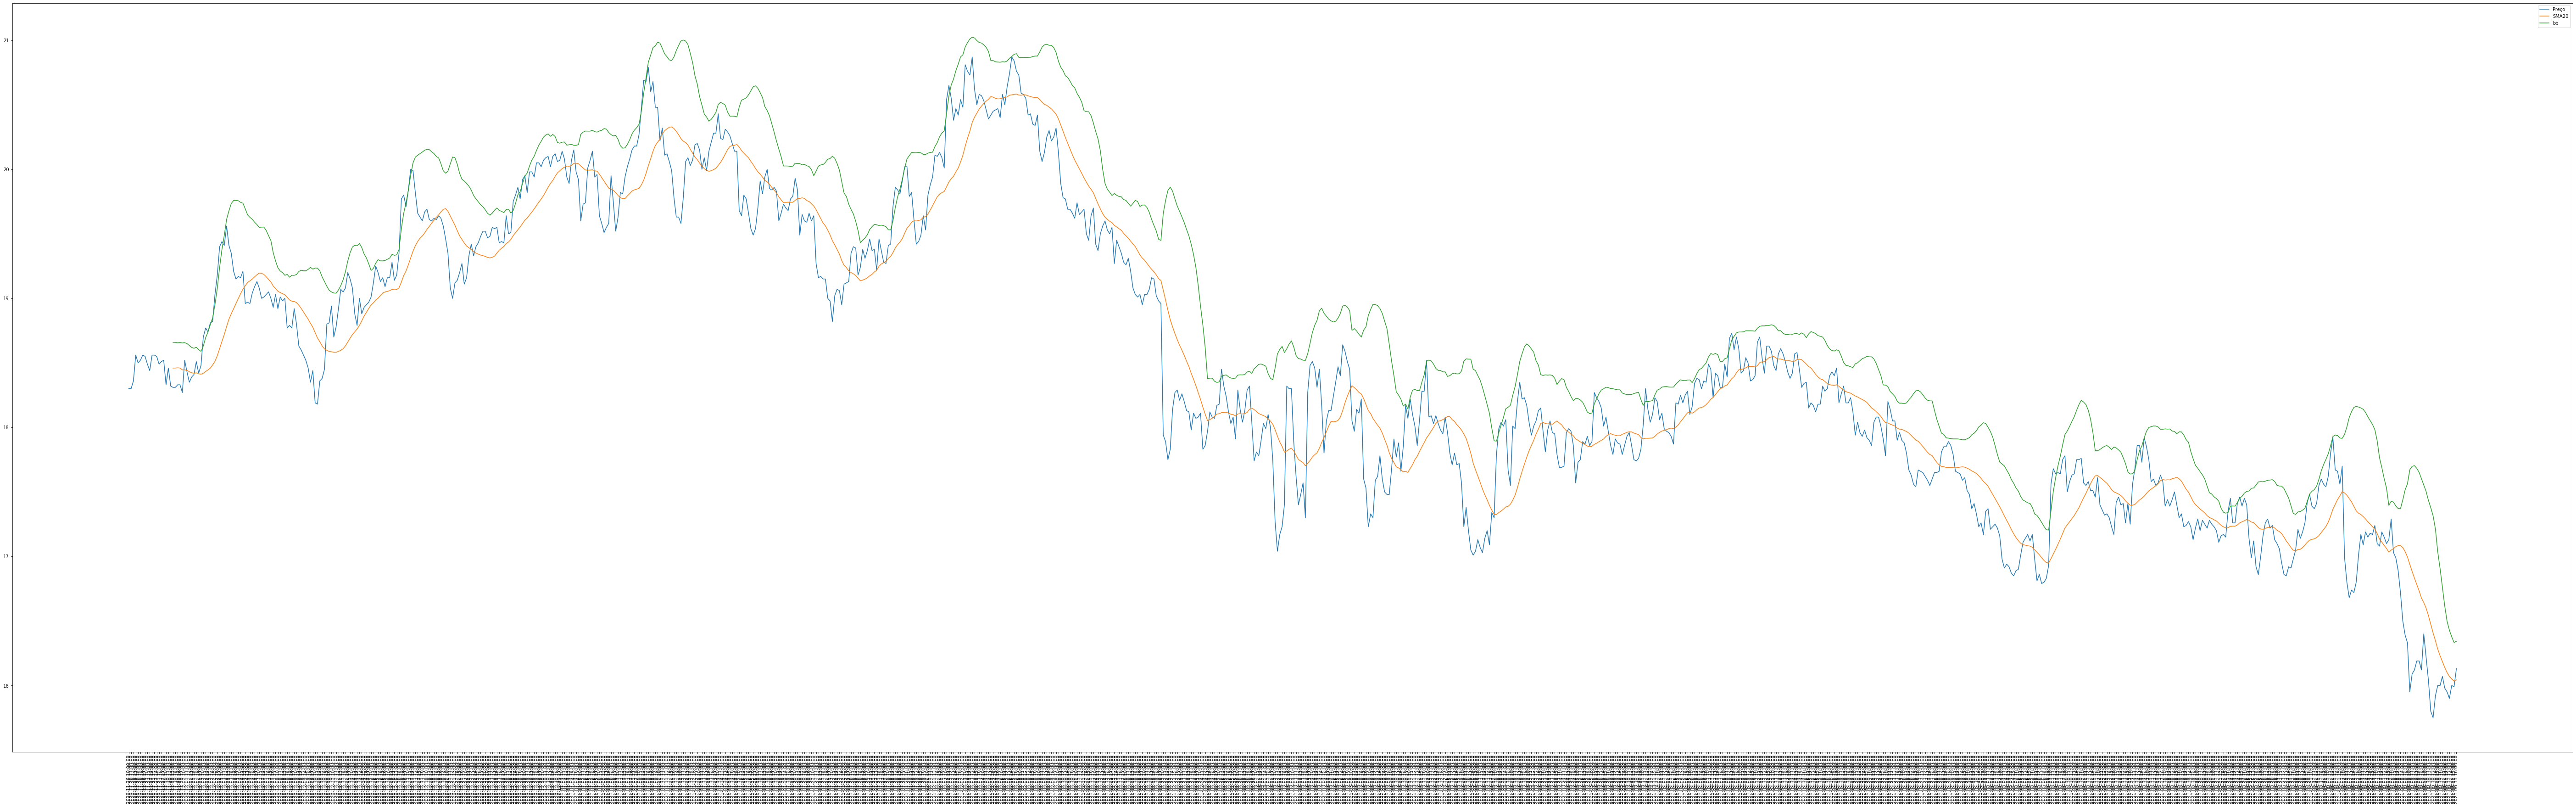

In [156]:
fromCSV.iloc[25:35]
plt.figure(figsize=(100,30))
plt.plot(fromCSV['time'],fromCSV['close'], label='Preço')
plt.plot(fromCSV['sma20'], label='SMA20')
plt.plot(fromCSV['bb_upper'], label='bb')
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.savefig("nice_try2.jpg")

In [98]:
for index, row in fromCSV.iterrows():
    # Se rompeu pra cima
    if(row['close'] >= row['bb_upper'] and row['adx_14'] < 35):
        print(index, row['time'])

28 2020-12-10
45 2021-01-08
127 2021-05-11


In [95]:
fromCSV = fromCSV.drop(columns=['time.1'])

In [ ]:
fromCSV.iloc[20:50]

In [154]:
adx = ta.adx(fromCSV['high'], fromCSV['low'], fromCSV['close'])


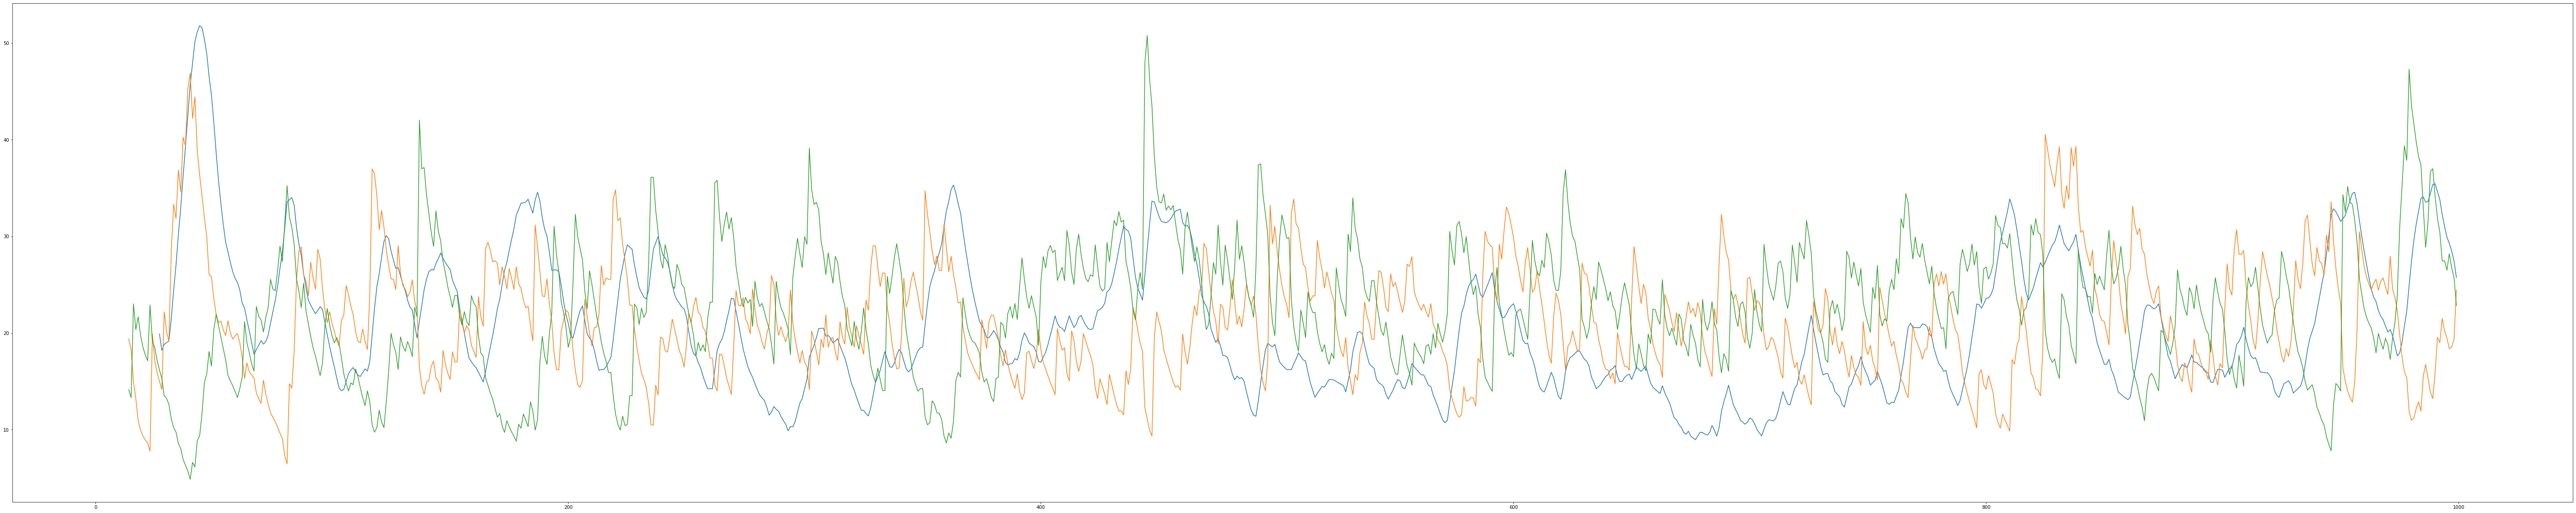

In [155]:

plt.figure(figsize=(100,20))
plt.plot(adx)

In [15]:
b3 = load_from_db("B3SA3", "D")
candles = b3.ta.cdl_pattern(name=["hammer", "invertedhammer", "hangingman", "shootingstar","dragonflydoji"])
# Example of filter 
# newdf = df.loc[(df.origin == "JFK") & (df.carrier == "B6")]
b3['CDL_HAMMER'] = candles['CDL_HAMMER']
b3['CDL_INVERTEDHAMMER'] = candles['CDL_INVERTEDHAMMER']
b3['CDL_HANGINGMAN'] = candles['CDL_HANGINGMAN']
b3['CDL_SHOOTINGSTAR'] = candles['CDL_SHOOTINGSTAR']
b3['CDL_DRAGONFLYDOJI'] = candles['CDL_DRAGONFLYDOJI']
filtered = b3.loc[(b3['CDL_HAMMER'] != 0.0) | (b3['CDL_HANGINGMAN'] != 0.0) |  (b3['CDL_SHOOTINGSTAR'] != 0.0)  |  (b3['CDL_INVERTEDHAMMER'] != 0.0)|  (b3['CDL_DRAGONFLYDOJI'] != 0.0)]

candles.head()

m=load_from_db step=start B3SA3
m=load_from_db step=success ./data/B3SA3-D.db.csv
[X] Please install TA-Lib to use hammer. (pip install TA-Lib)
[X] Please install TA-Lib to use invertedhammer. (pip install TA-Lib)
[X] Please install TA-Lib to use hangingman. (pip install TA-Lib)
[X] Please install TA-Lib to use shootingstar. (pip install TA-Lib)
[X] Please install TA-Lib to use dragonflydoji. (pip install TA-Lib)


KeyError: 'CDL_HAMMER'

In [21]:
fig = build_fig(b3)

fig.write_html('b3sa3.html')

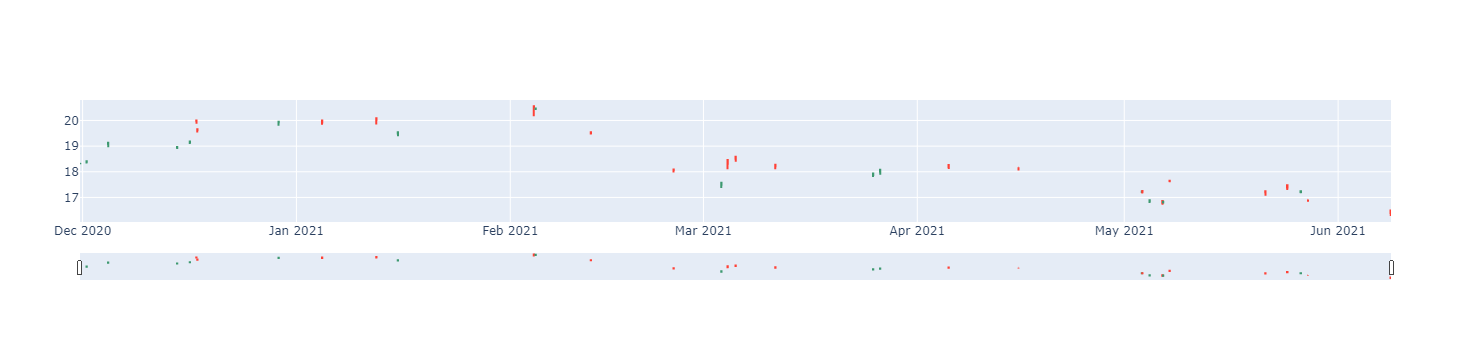

In [7]:
fig.write_html('out.html')